In [1]:
##__author__ federica bianco @fedhere
## for CUSP NYU PUI class
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt

s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)
%pylab inline



Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


**  How well does energy consumption relate to the number of units in the building? If number of units were a good proxy for occupancy then it should be a good predictor for energy consumption.**

** data on Energy consumption can be found from the Local Low 84 data here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z , but this dataset does not have **

** data on the number of Units per building can be found in the PLUTO dataset.**

# data acquisition

In [2]:
#download, move data to $PUIDATA, and read data in 
!curl -O https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv
cmd = "mv rows.csv " + os.getenv("PUIDATA")
#the line below is to check that my string is formatted right. I should remove it to make the notebook delivery ready
print (cmd)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4329k  100 4329k    0     0  9318k      0 --:--:-- --:--:-- --:--:--  9.8M
mv rows.csv /Users/fbianco/Dropbox//UI/PUIdata


In [3]:
os.system(cmd)

0

In [4]:
!curl -O http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip
#cmd = "mkdir " + os.getenv("PUIDATA") + "/Manhattan"
#print (cmd)

os.system("unzip  -d %s mn_mappluto_16v1.zip"%(os.getenv("PUIDATA") + '/Manhattan'))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.6M  100 11.6M    0     0  14.5M      0 --:--:-- --:--:-- --:--:-- 15.0M


256

In [5]:
#I want the files to be stored in a single directory so that the place is less messy
# so I am creating a subdir of PUIdata and putting the unzipped files there. (Not required)
#os.system(cmd)

#cmd = "mv mn* MN* PLUTO* " + os.getenv("PUIDATA")+"/Manhattan"
#print (cmd)
#os.system(cmd)
cmd = "ls " + os.getenv("PUIDATA")+"/Manhattan"
print (cmd)
os.system(cmd)
!ls $PUIDATA/Manhattan/*

ls /Users/fbianco/Dropbox//UI/PUIdata/Manhattan
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MNMapPLUTO.BBL.atx
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MNMapPLUTO.CD.atx
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MNMapPLUTO.LandUse.atx
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MNMapPLUTO.ZoneDist1.atx
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MNMapPLUTO.dbf
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MNMapPLUTO.prj
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MNMapPLUTO.sbn
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MNMapPLUTO.sbx
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MNMapPLUTO.shp
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MNMapPLUTO.shp.xml
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MNMapPLUTO.shx
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MN_Dcp_Mappinglot.dbf
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MN_Dcp_Mappinglot.prj
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MN_Dcp_Mappinglot.sbn
/Users/fbianco/Dropbox//UI/PUIdata/Manhattan/MN_Dcp_Mappinglot

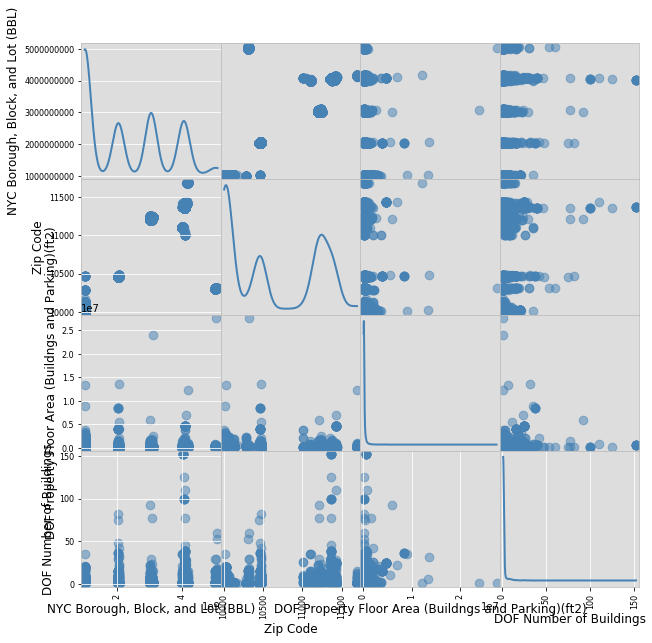

In [6]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
# exploring the data a bit
sfig = scatter_matrix (nrg, s=300, figsize=(10, 10), diagonal='kde')

bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/MNMapPLUTO.shp")

Figure 1: Scatter matrix of the data in the Energy dataset obtained from Local Law 84 in 2013. The columns of interest are 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)', and 'NYC Borough, Block, and Lot (BBL)'. Of these only 'NYC Borough, Block, and Lot (BBL)' is plotted in the scatter matrix, indicating that only this column contains numerical values. The other quantities plotted do not refer to energy and are therefore not insightful for this project.


## data cleaning and aggregation 
### checking the content of the datasets


In [7]:
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

In [8]:
bsize.columns


Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

clean up columns I am not using

In [9]:
nrg.drop(['Co-reported BBL Status',
       'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'], axis=1, inplace=True)

In [10]:
bsize.drop(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BldgArea', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'Version', 'XCoord', 'YCoord',
       'YearAlter1', 'YearAlter2', 'ZMCode', 'ZipCode',
       'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'ZoneMap',
       'geometry'], axis=1, inplace=True)

### converting  the relevant columns to numeric values and throwing away spurious entries

In [11]:
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='corece')

In [12]:
#the pd.to_numeric function does the same in a single line!!
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = \
            pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'], 
                          errors='coerce').astype(float)
#the line below checks that the conversion worked. should be removed in delivery ready ipynb
#nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

In [14]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


 There is a common column: the building block number. I can merge the dataframes on this value
 That way I will have all quantities of interests from the energy dataset and from the pluto dataset for every building
 It has two different names in the two dataframes

In [15]:
#renaming the quantity of interest 
#so i can refer to the column as an attribute if i want to while now i can't because the names contain spaces.
#also I want the same name for the common column BBL in both dataframes for merging
nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)':'BBL', 
                    'Reported Property Floor Area (Building(s)) (ft²)':'Reported Property Floor Area'}, 
           inplace=True)
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area
Record Number,,,
12086,1.000410e+09,NaN,918919.0
14354,4.021460e+09,NaN,NaN
12150,2.027620e+09,NaN,64200.0
12590,1.006700e+09,NaN,NaN
15591,2.048300e+09,NaN,50000.0


In [16]:
bsize.head()

,BBL,UnitsRes,UnitsTotal,YearBuilt
0,1.015450e+09,16,18,1920
1,1.007238e+09,50,50,1914
2,1.016800e+09,10,10,1910
3,1.013850e+09,29,32,1928
4,1.011970e+09,26,26,1900


In [18]:
bblnrgdata = pd.merge(nrg, bsize, how='inner', on=['BBL']).dropna()
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area,UnitsRes,UnitsTotal,YearBuilt
2,1.013110e+09,125.4,330000.0,0,56,1977
10,1.010140e+09,154.9,841709.0,0,2,1999
15,1.007660e+09,122.3,59468.0,0,8,1912
16,1.008150e+09,117.0,364000.0,0,24,1954
18,1.005050e+09,82.1,235370.0,0,24,1926


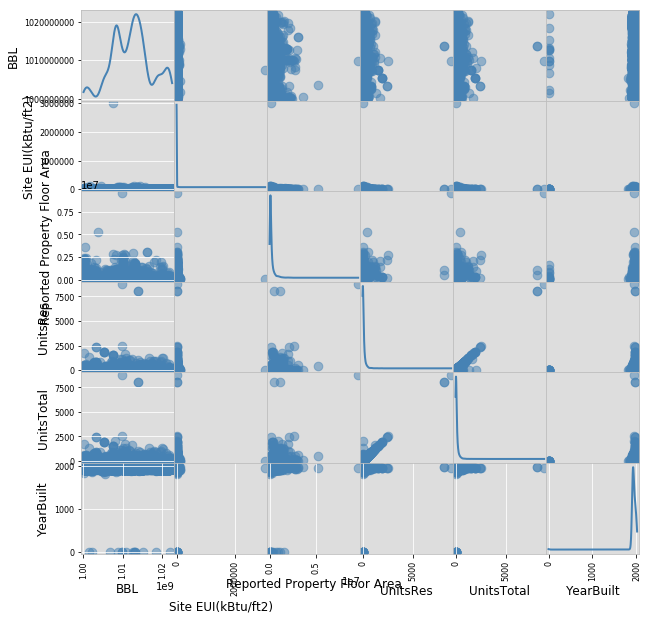

In [19]:
sfig = scatter_matrix (bblnrgdata, s=300, figsize=(10, 10), diagonal='kde')

Figure 2: Scatter matrix of the ultimate dataset: Each numeric column is plotted against each other one. On the diagonal a kernel density estimate is shown. There are some obvious patterns, but upon inspection they are rather trivial:  total units relates to residential units in a linear fashion, but that is not surprising. Floor area relates linearly (roughly) to number of untis.  All other relationships between the data are harder to spot in a linear plot. Note that the BBL is a categorical variable, but it has numerical values.


minimum building energy value 5344.0
maximum building energy value 350145188000.0


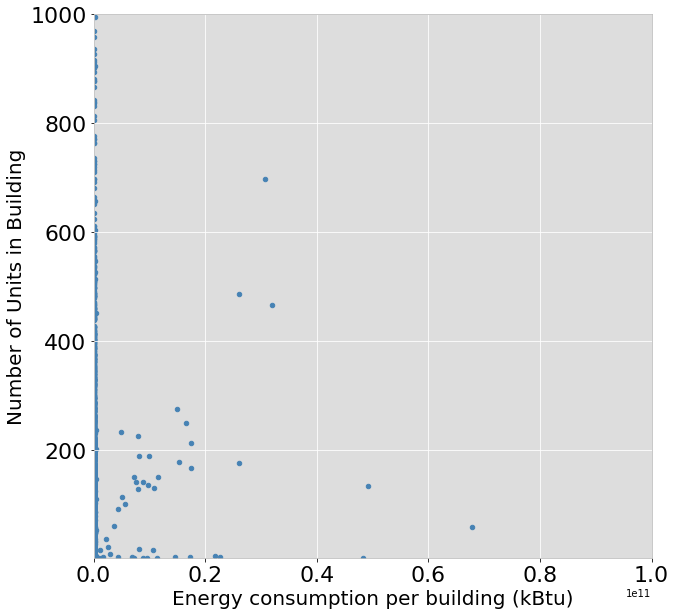

In [21]:
## multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata[\
    'Reported Property Floor Area'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
print ("minimum building energy value", bblnrgdata.nrg[bblnrgdata.nrg>0].min())
print ("maximum building energy value", bblnrgdata.nrg.max())
'''
indx= s1.UnitsTotal>1000
s1['UnitsTotal'][indx]=float('NaN')
indx= s1.UnitsTotal>1000
s1['UnitsTotal'][indx]=float('NaN')
'''
ax = bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal',
                     marker='o', figsize=(10, 10),  
                     xlim=(1000,1e11), ylim=(1,1000), fontsize=22)
yl = ax.set_ylabel("Number of Units in Building", fontsize=20)
xl = ax.set_xlabel("Energy consumption per building (kBtu)", fontsize=20)

Figure 3: Number of Units in the  Building as a function of energy consumed. The large range the data span, and the increasing sparcity at large x- and y-values make the plot not at all insightful if plotted over the full range. Notice the scientific notation on the x-axis: the units of energy are in 1e11: in the 100 millions of kBtu's.

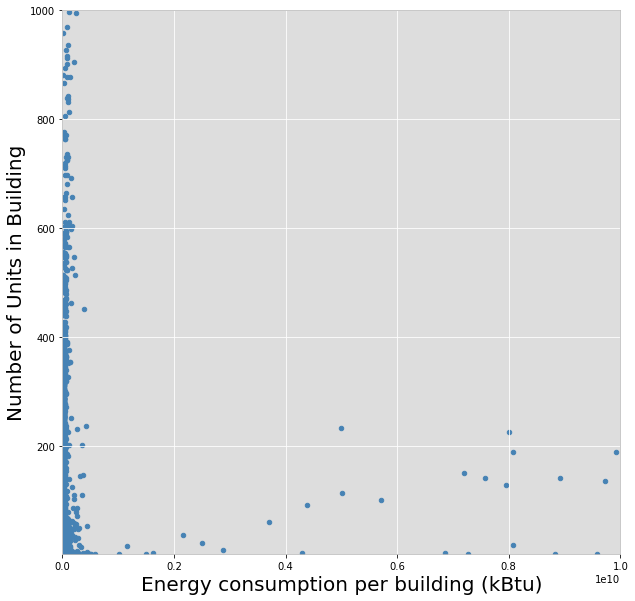

In [22]:
#cutting the limts in the plot to se if patterns emerge
ax = bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                marker='o',  figsize=(10, 10),   
                xlim=(1000,1e10), ylim=(1,1000))
yl = ax.set_ylabel("Number of Units in Building", fontsize=20)
xl = ax.set_xlabel("Energy consumption per building (kBtu)", fontsize=20)

Figure 4: Reducing the range of the plot shows the data but not patters obvious arose yet. Except for the increasing sparsity of data as either variable increases. This may indicate a logarithmic relationship. 

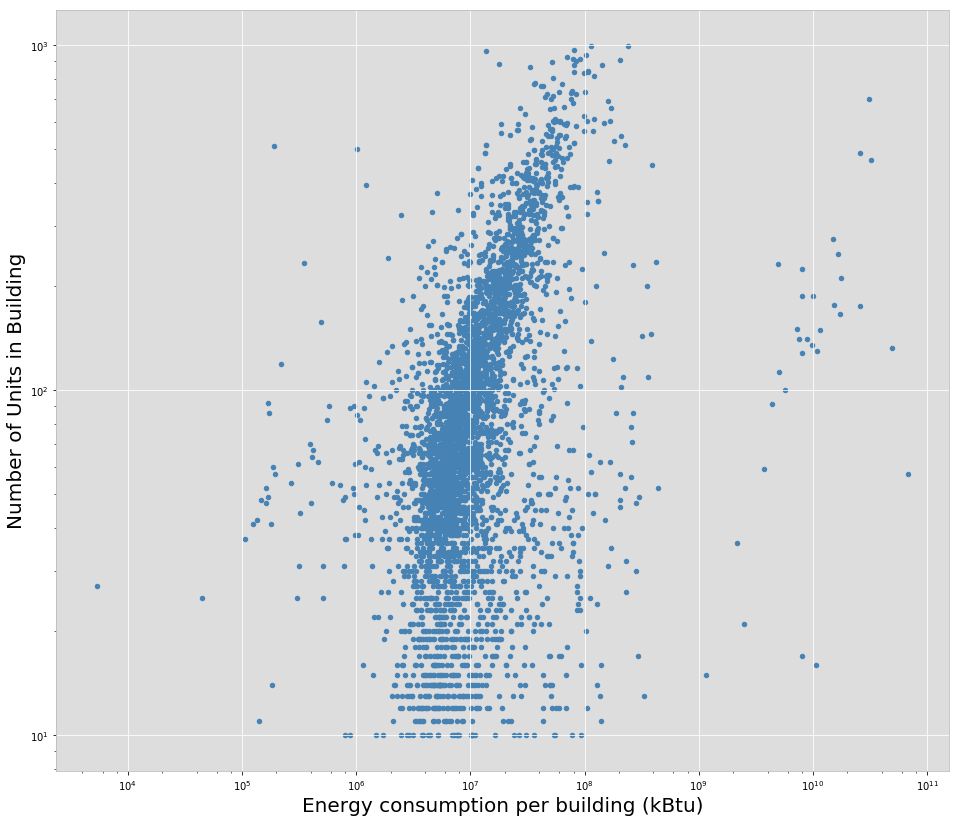

In [27]:
bblnrgdataCut = bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                           (bblnrgdata.UnitsTotal<1000)]

ax = bblnrgdataCut.plot(kind='scatter', x='nrg', y='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_ylabel("Number of Units in Building", fontsize=20)
xl = ax.set_xlabel("Energy consumption per building (kBtu)", fontsize=20)

Figure 4: Log-log plot of the Number of Units vs Energy consumed by each NYC building. A logarithmic pattern emerges as a linear pattern in log space.


# Modeling

## Define a chisquare function

In [62]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

## Define and calculate errors

In [79]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#errors on the measured quantities
errorsnrg = np.sqrt((bblnrgdataCut['Reported Property Floor Area'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)'])**2)

# better WOULD BE to calculate each error and add in quadrature: sqrt(1/A + 1/B) which becomes
#errorsnrg = np.sqrt(1.0 / bblnrgdataCut['Reported Property Floor Area'] + 1.0 / bblnrgdataCut['Site EUI(kBtu/ft2)'])
#but this leads to insane error values (insanely small)

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)


** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [80]:
errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.nrg / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Fit the data with a line in log space:  

In [81]:
def fit_line1(x, y):
    """Fits a line to data properly adding the dimensions required by statsmodels
    Arguments:
        x: series of exogenous variables
        y: seried of endogenous variables
    Output:
        slope, intercept of best fit line, and the full model fit
    """
    #print x
    X = sm.add_constant(x)
    #print X
    model = sm.OLS(y, X, missing='drop') # ignores entires where x or y is NaN
    fit = model.fit()
    return fit.params[1], fit.params[0], fit # could also return stderr in each via fit.bse



### Units vs Energy

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     828.3
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          1.22e-166
Time:                        22:53:39   Log-Likelihood:                -2567.3
No. Observations:                4271   AIC:                             5139.
Df Residuals:                    4269   BIC:                             5151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1103      0.033    187.053      0.000         6.046     6.174
UnitsTotal     0.4883      0.017     28.781      0.000         0.455     0.522
==============================================================================
Omnibus:                     2262.059   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44735.688
Skew:                           2.083   Prob(JB):                         0.00
Kurtosis:                      18.298   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

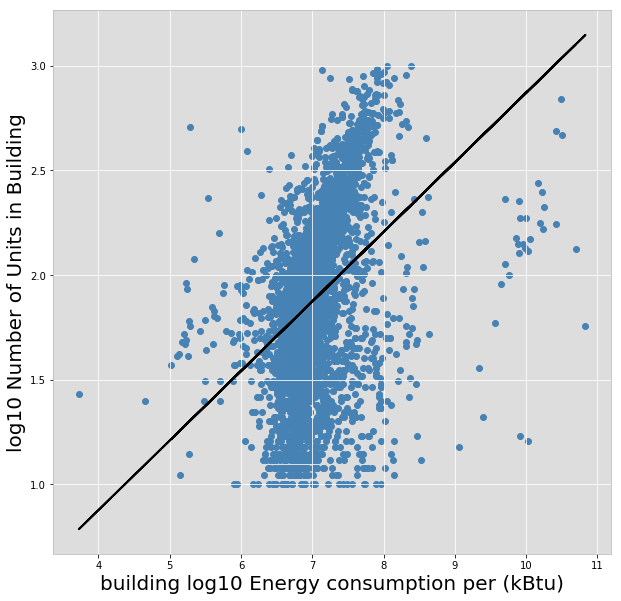

In [107]:
p1, p0, linmodel_0 = fit_line1(np.log10(bblnrgdataCut.nrg), 
                        np.log10(bblnrgdataCut.UnitsTotal))
pl.figure(figsize=(10,10))
pl.scatter(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal))
plot(np.log10(bblnrgdataCut.nrg), linmodel_0.predict(), 'k')
xl = pl.ylabel("log10 Number of Units in Building", fontsize=20)
yl = pl.xlabel("building log10 Energy consumption per (kBtu)", fontsize=20)
linmodel_1.summary()

Figure 5: Line for to Units vs Energy consumption in log space: a line fit indicates a power law relationship between the variables. The adjusted R^2 indicates only 16% of the variability is accounted for by this model (poor fit)


### Energy against Units

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     828.3
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          1.22e-166
Time:                        22:42:26   Log-Likelihood:                -2567.3
No. Observations:                4271   AIC:                             5139.
Df Residuals:                    4269   BIC:                             5151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1103      0.033    187.053      0.000         6.046     6.174
UnitsTotal     0.4883      0.017     28.781      0.000         0.455     0.522
==============================================================================
Omnibus:                     2262.059   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44735.688
Skew:                           2.083   Prob(JB):                         0.00
Kurtosis:                      18.298   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

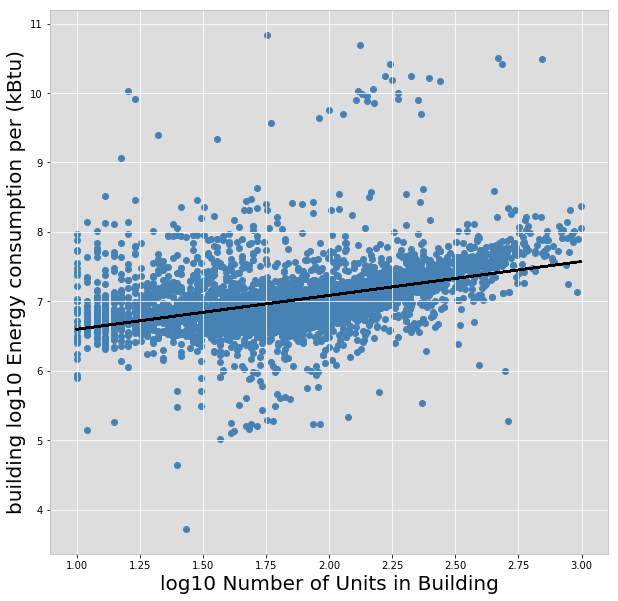

In [83]:
p1, p0, linmodel_1 = fit_line1(np.log10(bblnrgdataCut.UnitsTotal), 
                        np.log10(bblnrgdataCut.nrg))
pl.figure(figsize=(10,10))
pl.scatter(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg))
plot(np.log10(bblnrgdataCut.UnitsTotal), linmodel_1.predict(), 'k')
xl = pl.xlabel("log10 Number of Units in Building", fontsize=20)
yl = pl.ylabel("building log10 Energy consumption per (kBtu)", fontsize=20)
linmodel_1.summary()

Figure 6: Line fit to the log-log Energy vs Units. 
    The fit is better: A better fit is obtainable if there is a more homogeneous distribution 
        in the endogenous variable. However the R^2 is the same (see below). 
        Logically it also makes more sense to choose the Energy as endogenous variable and predict energy usage as function of number of Units. 

The largest error bar is for


,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area,UnitsRes,UnitsTotal,YearBuilt,nrg,errorsnrg,errorsunits
3809,1.019900e+09,0.1,53440.0,27,27,1909,5344.0,4.342945,0.08358


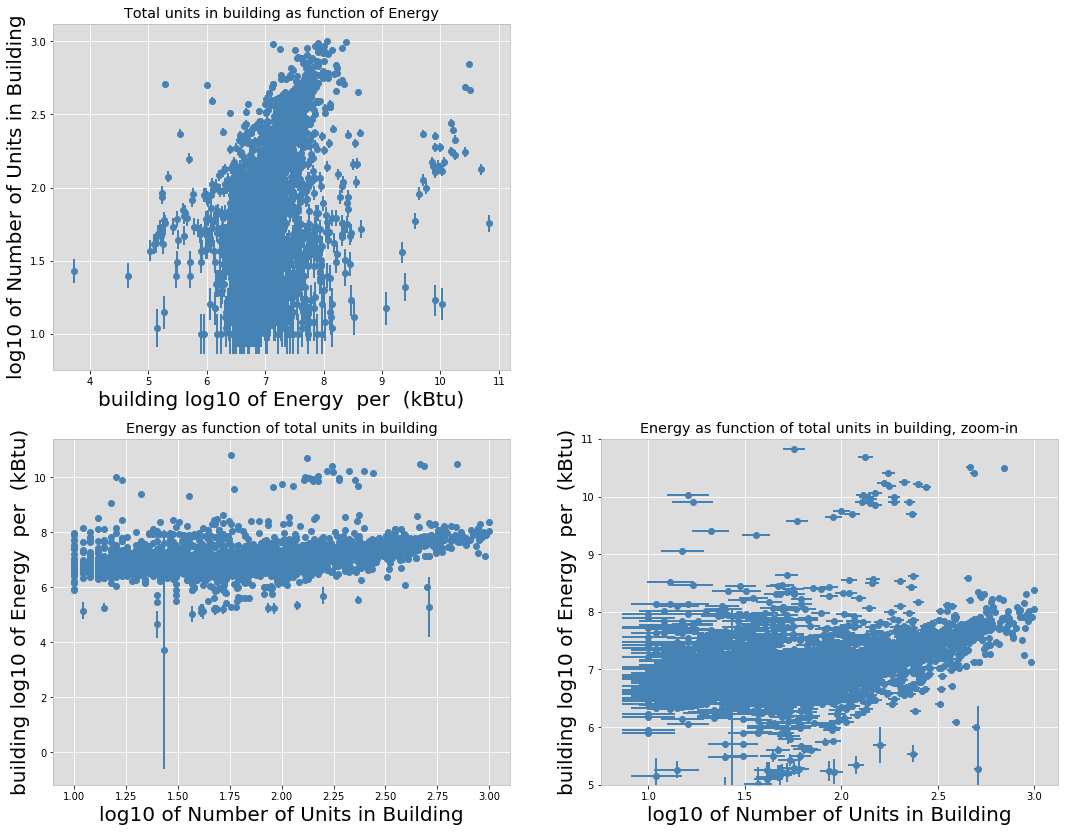

In [86]:
#I could also include errors for number of units
fig = pl.figure(figsize=(18, 14))
ax1 = fig.add_subplot(221)
ax1.errorbar(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal), 
                 yerr=bblnrgdataCut.errorsunits, fmt='o')
ax1.set_ylabel("log10 of Number of Units in Building", fontsize=20)
ax1.set_xlabel("building log10 of Energy  per  (kBtu)", fontsize=20)
ax1.set_title("Total units in building as function of Energy")


ax3 = fig.add_subplot(223)
ax3.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
                 yerr=bblnrgdataCut.errorsnrg, fmt='o')
ax3.set_xlabel("log10 of Number of Units in Building", fontsize=20)
ax3.set_ylabel("building log10 of Energy  per  (kBtu)", fontsize=20)
ax3.set_title("Energy as function of total units in building")

ax4 = fig.add_subplot(224)
ax4.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
                 yerr=bblnrgdataCut.errorsnrg, xerr=bblnrgdataCut.errorsunits, fmt='o')
ax4.set_xlabel("log10 of Number of Units in Building", fontsize=20)
ax4.set_ylabel("building log10 of Energy  per  (kBtu)", fontsize=20)
ax4.set_ylim(5,11)
ax4.set_title("Energy as function of total units in building, zoom-in")

print ("The largest error bar is for")
bblnrgdataCut[bblnrgdataCut.errorsnrg == bblnrgdataCut.errorsnrg.max()]


Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

### Compare the fit with chi square:

In [87]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = min(len(bblnrgdataCut.UnitsTotal) - np.isnan(bblnrgdataCut.UnitsTotal).sum(), 
         len(bblnrgdataCut.nrg) - np.isnan(bblnrgdataCut.nrg).sum()) - 2
print ("degrees of freedom:" , dof)

degrees of freedom: 4269


In [88]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict()) / float(dof)))

print ("Units vs Energy chi square per DOF w IV error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = bblnrgdataCut.errorsunits) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + bblnrgdataCut.errorsunits**2))  / dof))


Units vs Energy residuals (no errors include): 0.13
Units vs Energy chi square per DOF w IV error only: 114.22
Units vs Energy chi square per DOF : 101.11


In [89]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict()) / dof))

print ("Energy vs Units chi square per DOF w IV error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + bblnrgdataCut.errorsunits**2))  / dof))


Energy vs Units residuals (no errors include): 0.19
Energy vs Units chi square per DOF w IV error only: 818246458.59
Energy vs Units chi square per DOF : 113.39


### DISCUSSION:
** The model generated by fitting Energy vs Units is passing through the majority of the data much more closely than the model generated from Units vs Energy. Because of that *the model is preferible for our purposes*: it is less sensitive to outliersand and better describes the typical behavior. **

** However the R^2 of the models is the same, and depending on the treatment of the errors the chi^2 also suggests the Units vs Energy model is preferible! By a lot! This is a case of NEEDED VISUALIZATION: **

     1. the residuals without errors cannot be compared, because these quantities have units and the units are different. A comparison between residuals literally is equivalent to comparing apples to oranges. Dividing by the errors removes the units (divide kBtu^2/kBtu^2 and get unitless  quantities) so that a comparison between the second and third sets of chisq's above is meaningful.

     2. the chi sq (residuals with errors) is affected by how you calculate the errors. We assumed all quantities suffer from only poisson statistics. But we do not know even what the quantities measured mean: we do not know what the proper poisson statistics is on kBtu because we do not know what "a unit" is in that space. What if the unit was 1000 kBtu, meaning that that is the minimum countable quantity? Furthermore Poisson is always an underestimation. It is appropriate for the number of floors, because it is literally just counting objects, but there are going to be instrumental errors in the energy measurements, for example, in addition of Poisson statistics, which we are neglecting.

** If the errors were calculated correctly the chi squares would be reliable, but as it is they are not!**



** IMPORTANTLY: you cannot use the LR test to compare these models cause the models are NOT NESTED **

** Lastly, we  account for the degrees of freedom when comparing the chi square, but in this case we actually do not need to case because the number of degrees of freedom is the number of datapoints, minus the number of parameters in the model and both number of datapoints and number of parameters in model are the same in these two models.**

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

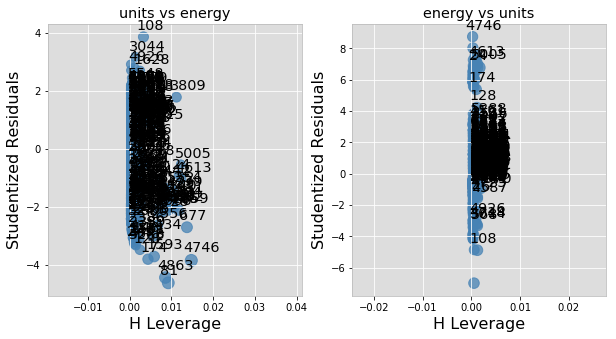

In [146]:
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(121)
sm.graphics.influence_plot(linmodel_0, external=False, alpha=1e-15, criterion='cooks', size=12, ax=ax)
ax.set_title("units vs energy");

ax = fig.add_subplot(122)
sm.graphics.influence_plot(linmodel_1, external=False, alpha=1e-15, criterion='cooks', size=12, ax=ax)
ax.set_title("energy vs units");


## Second degree polynomial fit

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logNrg   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     617.8
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          2.34e-236
Time:                        22:45:36   Log-Likelihood:                -2403.1
No. Observations:                4271   AIC:                             4812.
Df Residuals:                    4268   BIC:                             4831.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            8.0811      0.111     72.650      0.000         7.863     8.299
logUnits            -1.6807      0.119    -14.176      0.000        -1.913    -1.448
I(logUnits ** 2)     0.5706      0.031     18.471      0.000         0.510     0.631
==============================================================================
Omnibus:                     2407.772   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59002.981
Skew:                           2.200   Prob(JB):                         0.00
Kurtosis:                      20.669   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

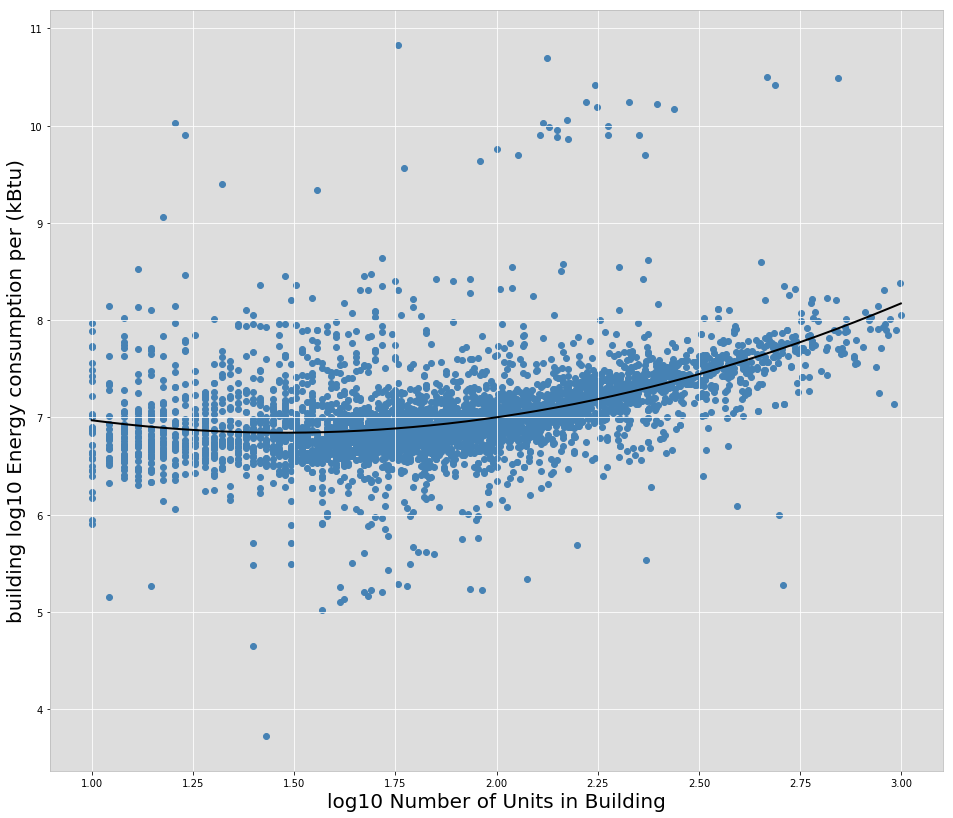

In [90]:
#I find the easiest way to use the formula package is to use a dataframe 
#with the quantities that are not linear already calculated

bblnrgdataCut['logNrg']  = np.log10(bblnrgdataCut.nrg)
bblnrgdataCut['logUnits']  = np.log10(bblnrgdataCut.UnitsTotal)

X = np.linspace(bblnrgdataCut['logUnits'].min(), bblnrgdataCut['logUnits'].max(), 1000)
curvemodel = smf.ols(formula = 'logNrg ~ logUnits + I(logUnits**2)', 
                          data = bblnrgdataCut).fit()
pl.figure(figsize=(16,14))
pl.scatter(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg))
plot(X, curvemodel.predict(exog = dict(logUnits = X)), 'k')
xl = pl.xlabel("log10 Number of Units in Building", fontsize=20)
yl = pl.ylabel("building log10 Energy consumption per (kBtu)", fontsize=20)
curvemodel.summary()

Figure 8: 2nd degree polynomial (parabolic) fit for to energy used by a building as a function of number of units in the building. 
    The Fit captures more variability (22%) than the linear models, as expected because of the addition of a parameter in the model.

## Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


In [91]:
alpha = 0.05
print ("LR : ", -2 * (linmodel_1.llf - (curvemodel.llf)))
print ("LR from statsmodels:", curvemodel.compare_lr_test(linmodel_1))
LR = curvemodel.compare_lr_test(linmodel_1)

print ("We ")
if LR[0] < 3.84: #0.05 level for 1 DOF chi sq distribution 
    print ("CANNOT") 
    
print ("reject the Null hypothesis that the restricted (linear) " + 
       "model is better than the 2nd degree polynomial fit with p-value ")
print ("p < %.3f"%alpha)

LR :  328.460515612
LR from statsmodels: (328.46051561187596, 2.0801346736060625e-73, 1.0)
We 
reject the Null hypothesis that the restricted (linear) model is better than the 2nd degree polynomial fit with p-value 
p < 0.050


## Plotting the likelihood surface (assuming gaussian statistics)

### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that maximizing the log likelihood is the same as minimizing the chi square).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values

In [92]:
#residuals without errors
resids_noerror = np.ones((200,200))*float('NaN')
indxs_noerror = np.ones((200,200,2))

for i,l in enumerate(np.arange (-100, 100, 1)):
    for j,k in enumerate(np.arange(-50.0, 50.0, 0.5)):
        #print j
        indxs_noerror[i,j] = (l, k)
        resids_noerror[i,j] = chi2(bblnrgdataCut.logNrg, bblnrgdataCut.logNrg * k + l)
        #print resids[i,j]

In [93]:
#residuals with errors (chisq)
resids = np.ones((200,200))*float('NaN')
indxs = np.ones((200,200,2))

for i,l in enumerate(np.arange (-100, 100, 1)):
    for j,k in enumerate(np.arange(-50.0, 50.0, 0.5)):
        #print j
        indxs[i,j] = (l, k)
        resids[i,j] = chi2(bblnrgdataCut.logNrg, bblnrgdataCut.logNrg * k + l, 
                           errors=np.sqrt(bblnrgdataCut.errorsnrg**2 + bblnrgdataCut.errorsunits**2))
        #print resids[i,j]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


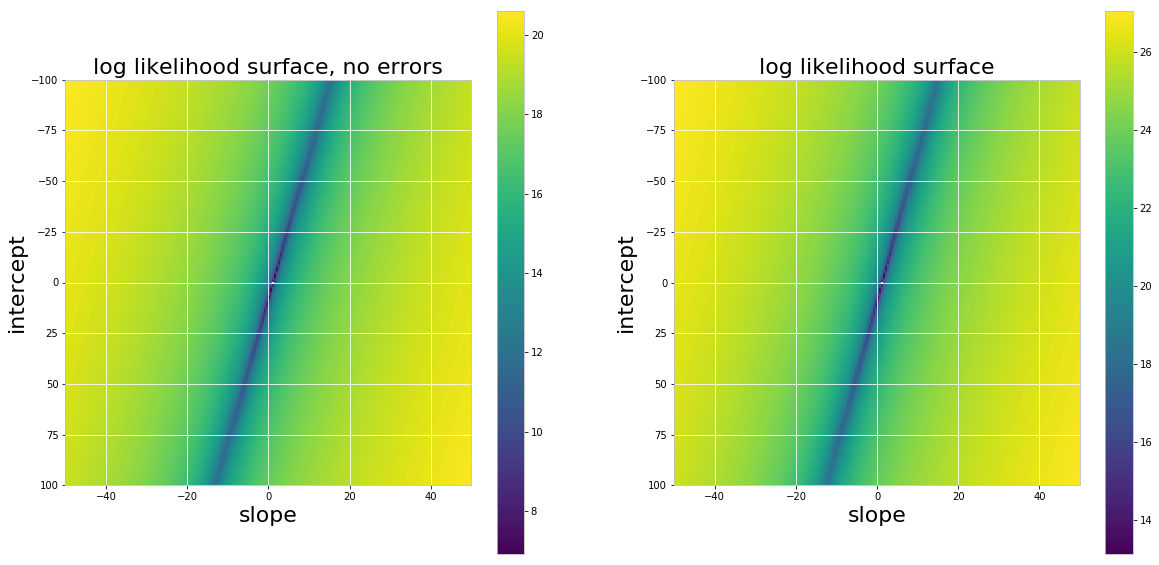

In [97]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title ("log likelihood surface, no errors", fontsize = 22)
pl.imshow(np.log(resids_noerror), extent = [-50,50,100,-100], aspect=0.5)
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar()

ax2 = fig.add_subplot(122)
ax2.set_title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(resids), extent = [-50,50,100,-100], aspect=0.5)
ax2.set_xlabel('slope', fontsize = 22)
ax2.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 10: The map of log likelihood for the minimixation with no errors (left) and with errors on both axes (right).
The  location of hte minimum is in a similar place and the side by side comparison does not allow to spot differences.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract


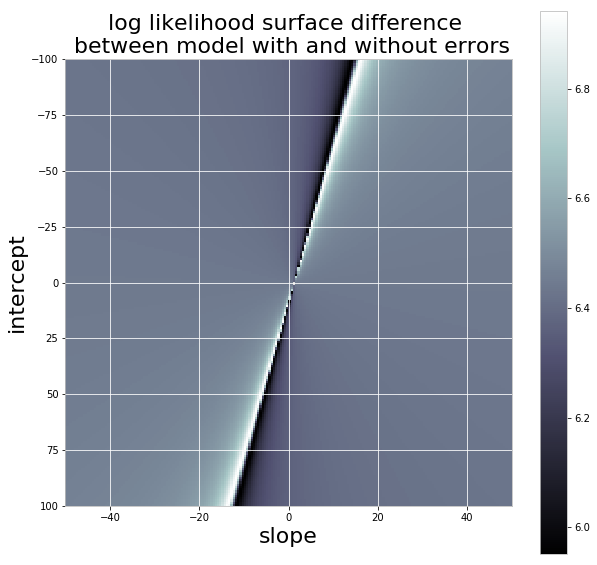

In [99]:
#plotting the difference between the 2 likelihood surfaces to see if the minimum is in the right place
ax1 = pl.figure(figsize=(10,10)).add_subplot(111)
ax1.set_title ("log likelihood surface difference \n between model with and without errors", fontsize = 22)
pl.imshow(np.abs(np.log(resids) - np.log(resids_noerror)), extent = [-50,50,100,-100], aspect=0.5, cmap='bone')
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 11: The difference in the log-likelihood surface generated by assuming equal (homoeschedastic) errors and by calculating the errors as shut noise (Poisson statistics) on the measurements. The location of the minimum is similar, while the 2d vector solution diverges away from the minimum.

# EXTRA CREDIT: a plot of anything related to these data

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


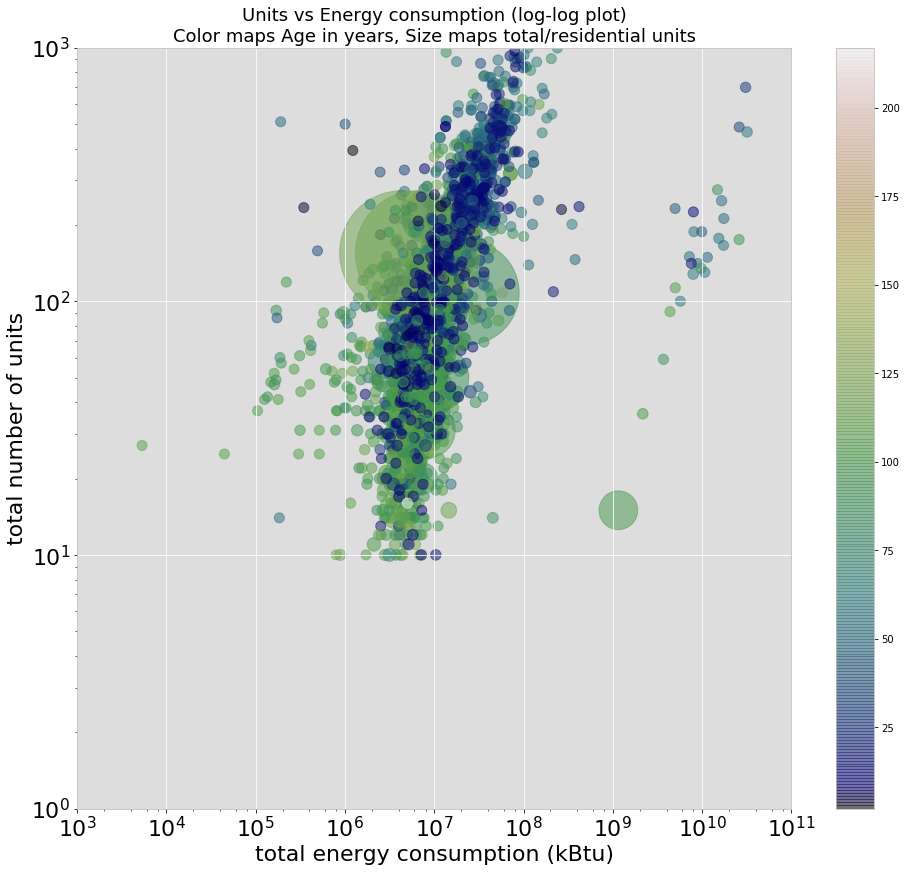

In [101]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
bblnrgdataCut['YearBuilt'][bblnrgdataCut['YearBuilt']<1800]=1800

bblnrgdataCut.plot(kind='scatter', x='nrg', y='UnitsTotal', 
                fontsize=22, colormap='gist_earth', alpha = 0.5, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), ax = ax,
                c= dt.datetime.today().year - bblnrgdataCut['YearBuilt'], 
                s=bblnrgdataCut['UnitsTotal']/bblnrgdataCut['UnitsRes'] * 100)
pl.title('Units vs Energy consumption (log-log plot)\nColor maps Age in years, Size maps total/residential units', 
         fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22);


Figure 11: Plot of Number of Units as a function of energy consumption for all NYC buildings with self reported energy consumption in the Local Law 84 database. The color of each datapoint representes the age: darker colors are buildings of more recent construction. The size of the mark represents the inverse of the fraction of residential units in the building (large datapoints indicate a small fraction of residential units, i.e. a comercial building). 

There is a weak color gradient where younger buildings dominate the higher portion of the plot. This could be interpreted as higher efficiency: at the same energy consumption younger buildings host more people. Or it could be driven by architectural changes: a trend to host the same number of people segregating them in more smaller units.

Aside from a few obvious outliers there is no obvious trend in fraction of residential units with building age, energy, or total number of units